## Load Trained Models

In [1]:
from models import TrainedModel
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

tqdm.pandas()

/Users/nehasrikanth/miniconda3/envs/para-nlu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
roberta_base = TrainedModel(
    '../modeling/chkpts/roberta-base-anli/',
    cache_dir='../modeling/hf-cache/',
)

roberta_large = TrainedModel(
    '../modeling/chkpts/roberta-large-anli/',
    cache_dir='../modeling/hf-cache/',
)

Loading model from ../modeling/chkpts/roberta-base-anli/
Loading model from ../modeling/chkpts/roberta-large-anli/


### Evaluate on full test split

In [ ]:
test = pd.read_json('/Users/nehasrikanth/Documents/paraphrase-nlu/raw-data/anli/test.jsonl', lines=True)
test['label'] = pd.read_csv('/Users/nehasrikanth/Documents/paraphrase-nlu/raw-data/anli/test-labels.lst', header=None)

In [ ]:
test['base-pred'] = test.progress_apply(
    lambda row: roberta_base._get_prediction(
        obs1=row['obs1'], obs2=row['obs2'], hyp1=row['hyp1'], hyp2=row['hyp2']
    ), axis=1
)

test['large-pred'] = test.progress_apply(
    lambda row: roberta_large._get_prediction(
        obs1=row['obs1'], obs2=row['obs2'], hyp1=row['hyp1'], hyp2=row['hyp2']
    ), axis=1
)


print(accuracy_score(test.label, test['roberta-base-pred'].map(lambda a: np.argmax(a) + 1)))
print(accuracy_score(test.label, test['roberta-large-pred'].map(lambda a: np.argmax(a) + 1)))

## Load paraphrase data and evaluate on original examples

In [3]:
pilot_paraphrases = pd.read_csv('../annotated-data/paraphrased_pilot.csv')
pilot_paraphrases['paraphrases_by_worker'] = pilot_paraphrases.paraphrases.map(eval)
pilot_paraphrases = pilot_paraphrases.drop(columns=['paraphrases', 'processed_assignments'])

In [4]:
pilot_paraphrases['hyp1_paraphrases'] = pilot_paraphrases.paraphrases_by_worker.map(
    lambda x: [p for w in x for p in w['hyp1_paraphrases']]
)
pilot_paraphrases['hyp2_paraphrases'] = pilot_paraphrases.paraphrases_by_worker.map(
    lambda x: [p for w in x for p in w['hyp2_paraphrases']]
)

In [5]:
pilot_paraphrases['base-pred'] = pilot_paraphrases.progress_apply(
    lambda row: roberta_base._get_prediction(
        obs1=row['obs1'], obs2=row['obs2'], hyp1=row['hyp1'], hyp2=row['hyp2']
    ), axis=1
)

pilot_paraphrases['large-pred'] = pilot_paraphrases.progress_apply(
    lambda row: roberta_large._get_prediction(
        obs1=row['obs1'], obs2=row['obs2'], hyp1=row['hyp1'], hyp2=row['hyp2']
    ), axis=1
)


print(accuracy_score(pilot_paraphrases.label, pilot_paraphrases['base-pred'].map(lambda a: np.argmax(a) + 1)))
print(accuracy_score(pilot_paraphrases.label, pilot_paraphrases['large-pred'].map(lambda a: np.argmax(a) + 1)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:20<00:00,  5.69it/s]

0.7391304347826086
0.8869565217391304


In [38]:
import random

def get_random_paraphrased_example_h1_h2(row):
    idx = random.randrange(0, 9)
    return {
        'obs1': row['obs1'], 'obs2': row['obs2'],
        'hyp1': row.hyp1_paraphrases[idx], 'hyp2': row.hyp2_paraphrases[idx]
    }
    
def get_random_paraphrased_example_h1(row):
    idx = random.randrange(0, 9)
    return {
        'obs1': row['obs1'], 'obs2': row['obs2'],
        'hyp1': row.hyp1_paraphrases[idx], 'hyp2': row['hyp2']
    }

def get_random_paraphrased_example_h2(row):
    idx = random.randrange(0, 9)
    return {
        'obs1': row['obs1'], 'obs2': row['obs2'],
        'hyp1': row['hyp1'], 'hyp2': row.hyp2_paraphrases[idx]
    }

def get_zipped_examples(row):
    return [{'obs1': row['obs1'], 'obs2': row['obs2'], 'hyp1': h1, 'hyp2': h2} 
            for h1, h2 in zip(row.hyp1_paraphrases, row.hyp2_paraphrases)]



In [29]:
h1_h2 = pd.concat([h1_h2, h1_h2.progress_map(lambda r: roberta_large._get_prediction(**r))], axis=1)
h1 = pd.concat([h1, h1.progress_map(lambda r: roberta_large._get_prediction(**r))], axis=1)
h2 = pd.concat([h2, h2.progress_map(lambda r: roberta_large._get_prediction(**r))], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:20<00:00,  5.62it/s]


In [43]:
zipped_examples = pilot_paraphrases.apply(get_zipped_examples, axis=1)

zipped_examples = pd.concat([
    pilot_paraphrases[['label', 'large-pred', 'hyp1', 'hyp2']],
    zipped_examples.progress_map(lambda example_list: [roberta_large._get_prediction (**e) for e in example_list])
], axis=1
).rename(columns={0: 'para-preds'})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [02:58<00:00,  1.56s/it]


<AxesSubplot:ylabel='Frequency'>

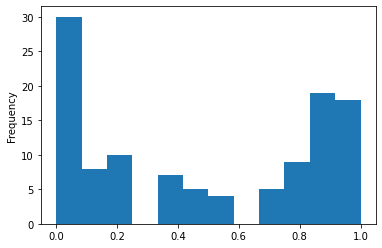

In [73]:
zipped_examples['para-preds-argmax'] = zipped_examples['para-preds'].map(lambda x: [np.argmax(i) + 1 for i in x])

zipped_examples.apply(
    lambda row: sum(1 for i in row['para-preds-argmax'] if i == row.label)/len(row['para-preds-argmax']), axis=1
).plot.hist(bins=12)

In [ ]:
def calculate_flip_rate(old_pred, new_pred):
    return sum(old_pred.map(np.argmax) != new_pred.map(np.argmax)) / len(old_pred)

In [ ]:
print(calculate_flip_rate(pilot_paraphrases['large-pred'], pilot_paraphrases['large-pred-para-h1-h2']))
print(calculate_flip_rate(pilot_paraphrases['large-pred'], pilot_paraphrases['large-pred-para-h1']))
print(calculate_flip_rate(pilot_paraphrases['large-pred'], pilot_paraphrases['large-pred-para-h2']))



In [11]:
list(zip(pilot_paraphrases.hyp1_paraphrases.iloc[0], pilot_paraphrases.hyp2_paraphrases.iloc[0]))

[('The other team felt bad enough to give them another ball.',
  'The other team was happy and gave them a ball.'),
 ('The other team had compassion and replaced their ball.',
  'The other team was delighted to give them a ball.'),
 ('The other team gave them a ball since they felt bad. ',
  'The other team was so happy to replace their ball. '),
 ('The other team took pity on their opponents and gave them another ball',
  'The other team gloated about being rich and gave them another ball'),
 ('The other team was generous enough to give their opponents a ball',
  'Being more fortunate that they are, the team gave the opposing team a ball while laughing'),
 ('Feeling sympathetic, the other team then gave the opposing team their ball',
  'The other team went into a laughing fit after hearing that the opposing team was poor so they gave them the ball'),
 ('Due to the other team feeling bad, they gave them the ball',
  'Another ball was given to the team because of their elation'),
 ('The